## [이미지 밝기에 따른 고양이 수염 붙이기 영향분석 - Dark]

## 0. 환경구축 및 필요한 패키지 import

In [1]:
!mkdir -p ~/aiffel/camera_sticker/models
!mkdir -p ~/aiffel/camera_sticker/images

In [2]:
!ln -s ~/data/* ~/aiffel/camera_sticker/images

ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/hero.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/image.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/king.png': File exists


In [3]:
import os
import cv2  # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import dlib  # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


## Step 1. 스티커 구하기 or 만들기

고양이 수염 스티커는 flaticon 사이트에서 다운받았고 스마트폰으로 셀카를 landscapee로 찍어서 png로 변환한 다음 images 폴더에 저장하고 BGR을 RGB로 변환하여 출력

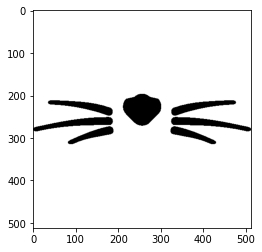

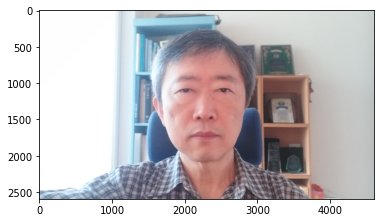

In [4]:
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/'
img_sticker = cv2.imread(image_path+'24674.png')
YJKim_L = cv2.imread(image_path+'YJKim_Land.png')
YJKim_L_rgb = cv2.cvtColor(YJKim_L, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker)  # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show()
plt.imshow(YJKim_L_rgb)
plt.show()

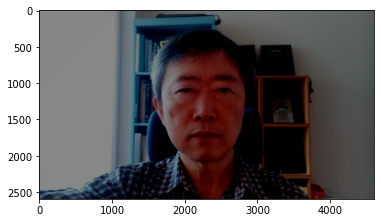

In [25]:
# 사진 이미지를 어두운 상태로 변환  ## ===================================================================
val = 120
array = np.full(YJKim_L_rgb.shape, (val, val, val), dtype=np.uint8)
YJKim_Dark = cv2.subtract(YJKim_L_rgb, array)
plt.imshow(YJKim_Dark)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

rectangles[[(1635, 869) (2785, 2019)]]


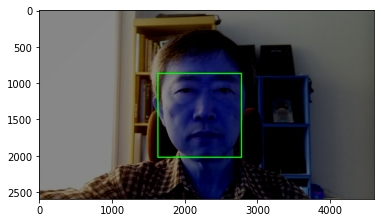

In [26]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()  # 기본 얼굴 감지기를 반환

dlib_rects = detector_hog(YJKim_Dark, 1)  # (image, num of image pyramid)  ## ============================

# 찾은 얼굴 영역 박스 리스트
img_show = YJKim_Dark.copy()  ## =========================================================================
print(dlib_rects)   
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 16, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
# Landmark 검출을 위하여 Dlib의 제공되는 모델을 사용

! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
! cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2022-10-11 00:47:25--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.7MB/s    in 3.3s    

2022-10-11 00:47:28 (18.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [28]:
# 저장한 landmark 모델을 불러옵니다.

# 저장한 landmark 모델의 주소를 model_path 변수에 저장
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크의 위치를 저장할 list 생성
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(YJKim_Dark, dlib_rect)  ## ===============================================
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points)
        
print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


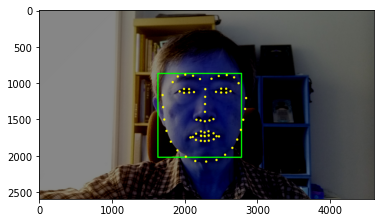

In [29]:
# 랜드마크를 영상에 출력

# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 16, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 16이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

# RGB 이미지로 전환
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# 이미지를 준비
plt.imshow(img_show_rgb)
# 이미지를 출력
plt.show()

## Step 3. 스티커 적용 위치 확인하기

In [30]:
# 기준점으로 사용할 코의 좌표를 먼저 확인

# 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])  # 코의 index는 30 입니다
    x = landmark[30][0]   # 이미지에서 코 부위의 x값
    y = landmark[30][1]   # 이미지에서 코 부위의 y값
    # w, h: 얼굴 영역의 가로/세로를 차지하는 픽셀의 수
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(2282, 1395)
(x,y) : (2282,1395)
(w,h) : (1151,1151)


In [31]:
# 준비해 둔 스티커 이미지를 읽어서 얼굴영역과 같은크기로 조정

image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/24674.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(image_path)  # cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 고양이 수염 이미지의 차원 확인

(1151, 1151, 3)


In [32]:
# 스티커 이미지를 적용할 얼굴영역 내에서의 좌표를 계산

# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 2288
# y는 이미지에서 코 부위의 y값 = 1404
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 1151
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 1151
refined_x = x - (w // 2)
refined_y = y - (h // 2)
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
# 이미지 시작점은 top-left 좌표이기 때문
# 즉, refined_x, refined_y값에서 스티커 이미지가 시작됨
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (1707,820)


x, y 모두 양수값이므로 스티커가 원본이미지를 벗어나지 않는다.

## Step 4. 스티커 적용하기

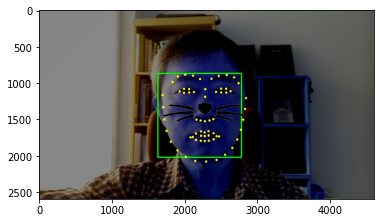

In [33]:
# 원본 이미지에 스티커를 적용

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용
# 스티커 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법

# 아래 코드에서는 img_sticker가 255(흰색)일 경우에는 sticker_area를 적용하고,
# 나머지 부분은 img_sticker를 적용
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] \
    = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

# 고양이 수염 이미지를 적용한 이미지를 보여줌
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

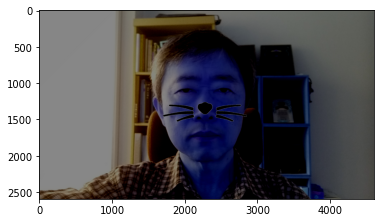

In [35]:
# bounding box와 landmark를 검출하기 전의 원본 이미지의 동일 좌표에 스티커 이미지를 합성

sticker_area = YJKim_Dark[refined_y:refined_y +img_sticker.shape[0],  ## =================================
                          refined_x:refined_x +img_sticker.shape[1]]

# YJKim_Dark는 bgr 원본 이미지이며 여기에 스티커 이미지를 덮어 씌움  ## ==================================
YJKim_Dark[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x +img_sticker.shape[1]] \
    = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

# bgr 이미지를 rgb 이미지로 전환하여 출력
plt.imshow(cv2.cvtColor(YJKim_Dark, cv2.COLOR_BGR2RGB))  ## ==============================================
plt.show()

## 소회
매우 어두운 사진에서도 고양이 수염이 코 부위에 잘 위치하였다.
이 landmark 모델이 어두운 사진에서도 잘 작동되는 훌륭한 모델임을 알 수 있다.